<a href="https://colab.research.google.com/github/Daniel7363/hyperparameter_tuning/blob/main/hyperparameter_opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
pip install optuna tabulate


Installing packages

In [31]:
import kagglehub
import pandas as pd
import os
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
import logging
from tabulate import tabulate
# Disable Optuna's logging output
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Only log warnings and errors

import the necessary libraries

In [32]:
# Load the dataset
df_directory = kagglehub.dataset_download('maajdl/yeh-concret-data')

# List the files in the downloaded directory to find the dataset file
print("Contents of the directory:", os.listdir(df_directory))

# Assuming you find a CSV file , load it into a DataFrame
file_path = os.path.join(df_directory, 'Concrete_Data_Yeh.csv')

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)

# StandardScaler to scale the features
scaler = StandardScaler()

# Display the first 5 records

print("First 5 records:", df.head())


# Define features (X) and target (y)
X = df.drop(columns=['csMPa'])  # Example target column
y = df['csMPa']

# Split into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform the training set
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test set (use the same scaler to avoid data leakage)
X_test_scaled = scaler.transform(X_test)



Contents of the directory: ['Concrete_Data_Yeh.csv']
First 5 records:    cement   slag  flyash  water  superplasticizer  coarseaggregate  \
0   540.0    0.0     0.0  162.0               2.5           1040.0   
1   540.0    0.0     0.0  162.0               2.5           1055.0   
2   332.5  142.5     0.0  228.0               0.0            932.0   
3   332.5  142.5     0.0  228.0               0.0            932.0   
4   198.6  132.4     0.0  192.0               0.0            978.4   

   fineaggregate  age  csMPa  
0          676.0   28  79.99  
1          676.0   28  61.89  
2          594.0  270  40.27  
3          594.0  365  41.05  
4          825.5  360  44.30  


loads the dataset to a Dataframe

splits the dataset into training and testing datasets

and applies standard scaler for preprocessing

In [33]:
# Define the objective function for Bayesian Optimization using Optuna (only for GradientBoostingRegressor)
def objective(trial):
    # Hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 200)  # Number of trees
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)  # Learning rate (log scale)
    max_depth = trial.suggest_int('max_depth', 3, 10)  # Max depth of trees
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)  # Minimum samples to split a node
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)  # Minimum samples in a leaf
    subsample = trial.suggest_float('subsample', 0.8, 1.0)  # Fraction of samples for training each tree

    # Create a GradientBoostingRegressor with the chosen hyperparameters
    gb = GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        random_state=42
    )

    # Train the model
    gb.fit(X_train_scaled, y_train)

    # Predict on the validation set
    y_pred = gb.predict(X_test_scaled)

    # Calculate the mean squared error (MSE) and then take the square root to get RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # Take square root of MSE to get RMSE

    # Normalize RMSE: Divide by the range of the target variable
    rmse_normalized = rmse / (y.max() - y.min())  # Normalize RMSE to be between 0 and 1

    return rmse_normalized  # We are minimizing normalized RMSE

# Create an Optuna study and optimize the objective function for GradientBoostingRegressor
study = optuna.create_study(direction='minimize',study_name='GradientBoostingRegressor')  # Minimize the normalized RMSE
study.optimize(objective, n_trials=100, n_jobs=-1)  # Run 100 trials


# Train the final GradientBoostingRegressor model with the best hyperparameters
best_params = study.best_params
best_gb = GradientBoostingRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    subsample=best_params['subsample'],
    random_state=42
)

# Fit the final GradientBoostingRegressor model
best_gb.fit(X_train_scaled, y_train)

# Feature Importance Calculation
feature_importance_gb = best_gb.feature_importances_

# Create a DataFrame to store feature importance
feature_importance_df_gb = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance_gb
})

# Sort by importance
feature_importance_df_gb = feature_importance_df_gb.sort_values(by='Importance', ascending=False)

threshold = 0.05

# Select top features based on importance
top_features_gb = feature_importance_df_gb[feature_importance_df_gb['Importance'] > threshold]['Feature']


# Retrain the model using only selected features
X_train_selected_gb = X_train_scaled[:, [X.columns.get_loc(feature) for feature in top_features_gb]]
X_test_selected_gb = X_test_scaled[:, [X.columns.get_loc(feature) for feature in top_features_gb]]

# Train the model on the selected features
best_gb.fit(X_train_selected_gb, y_train)

# Make predictions
y_pred_selected_gb = best_gb.predict(X_test_selected_gb)



# Calculate the final RMSE and R² for GradientBoostingRegressor
final_rmse_gb = np.sqrt(mean_squared_error(y_test,  y_pred_selected_gb))
final_r2_gb = r2_score(y_test,  y_pred_selected_gb)



# ---------------------------
# Random Forest Regressor (Default)
# ---------------------------
rf = RandomForestRegressor(n_estimators=100, random_state=42)  # Use default hyperparameters
rf.fit(X_train_scaled, y_train)

# Predict on the test set
final_predictions_rf = rf.predict(X_test_scaled)

# Calculate the final RMSE and R² for RandomForestRegressor
final_rmse_rf = np.sqrt(mean_squared_error(y_test, final_predictions_rf))
final_r2_rf = r2_score(y_test, final_predictions_rf)



# Normalize RMSE for RandomForestRegressor
final_rmse_rf_normalized = final_rmse_rf / (y.max() - y.min())


# Normalize RMSE for GradientBoostingRegressor
final_rmse_gb_normalized = final_rmse_gb / (y.max() - y.min())



Defines the objective function for Bayesian optimazation for the Gradient Boosting Regressor which first sets up the model(gradient boosting regressor)
and calculates the normalized RMSE.


Using optuna, it runs a study with 100 trials to find the best hyperparameters.

After finding the best values, it trains the model and performs a feature selection with an importance threshold of 0.05


it then restrains the model to use the selected features and trains the model again. After it calculates the normalized RMSE and R-squared for the final model.

Also, runs the Random forest regressor using default hyperparameters and calculates the normalized RMSE and R-squared for it as well.


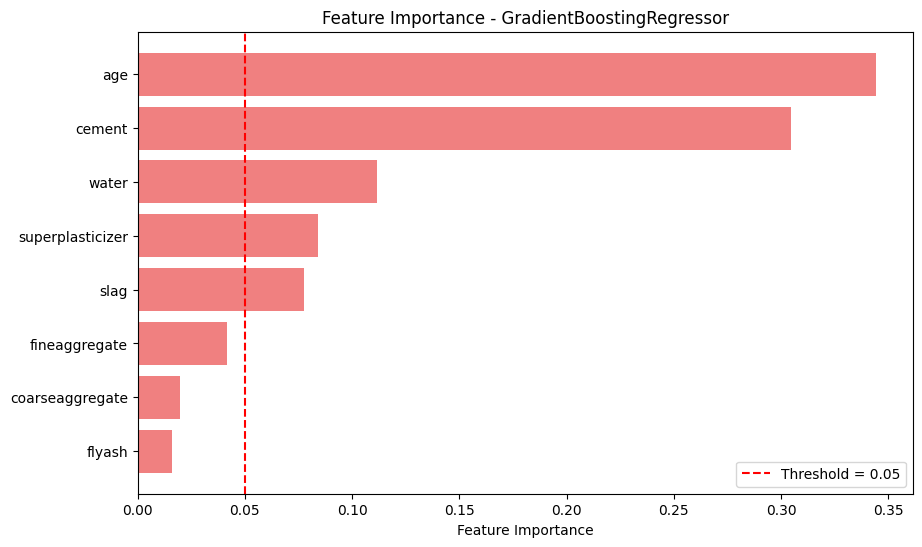

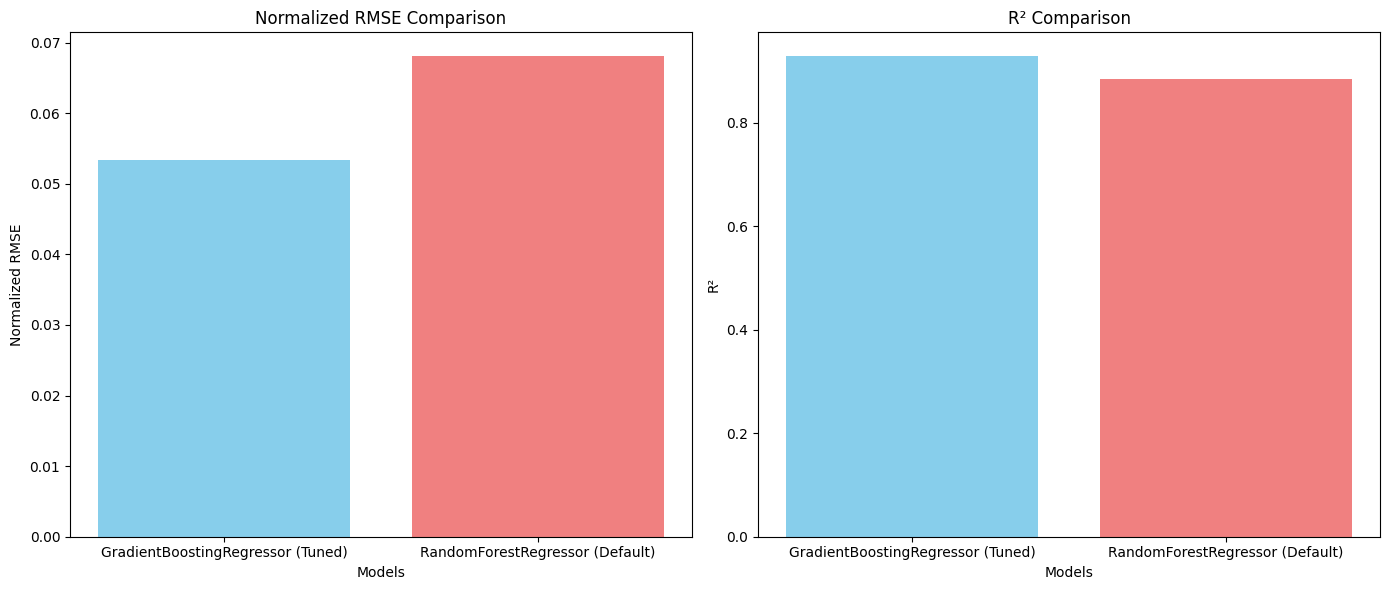

Best hyperparameters for GradientBoostingRegressor found:  {'n_estimators': 149, 'learning_rate': 0.15407029476628492, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 10, 'subsample': 0.9267593050855081}

Model Comparison Results:
                               Model  Normalized RMSE        R²
0  GradientBoostingRegressor (Tuned)         0.053350  0.928830
1    RandomForestRegressor (Default)         0.068061  0.884169

Comparison of True Values and Predicted Values (Scaled):
+-------------+---------------------------------------+-----------------------------------+
| True Values | Scaled Predictions (GradientBoosting) | Scaled Predictions (RandomForest) |
+-------------+---------------------------------------+-----------------------------------+
|    52.91    |          53.031185823188935           |         51.85849999999996         |
|    55.9     |          42.478652594790965           |         40.67020000000005         |
|    74.5     |           73.83399632265201    

In [34]:
# ---------------------------
# Plot the results using Matplotlib
# ---------------------------

# Plot the feature importances for GradientBoostingRegressor
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df_gb['Feature'], feature_importance_df_gb['Importance'], color='lightcoral')
plt.xlabel('Feature Importance')
plt.title('Feature Importance - GradientBoostingRegressor')
plt.gca().invert_yaxis()  # To have the highest importance on top
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.legend()

plt.show()

models = ['GradientBoostingRegressor (Tuned)', 'RandomForestRegressor (Default)']
rmse_normalized_values = [final_rmse_gb_normalized, final_rmse_rf_normalized]
r2_values = [final_r2_gb, final_r2_rf]

# Create a 1x2 grid for subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Normalized RMSE
axes[0].bar(models, rmse_normalized_values, color=['skyblue', 'lightcoral'])
axes[0].set_title('Normalized RMSE Comparison')
axes[0].set_xlabel('Models')
axes[0].set_ylabel('Normalized RMSE')

# Plot R² Comparison
axes[1].bar(models, r2_values, color=['skyblue', 'lightcoral'])
axes[1].set_title('R² Comparison')
axes[1].set_xlabel('Models')
axes[1].set_ylabel('R²')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# -----------------------------------
# Final Evaluation Results Summary
# -----------------------------------

# Output the best hyperparameters found by Optuna for GradientBoostingRegressor
print("Best hyperparameters for GradientBoostingRegressor found: ", study.best_params)

results = {
    "Model": ["GradientBoostingRegressor (Tuned)", "RandomForestRegressor (Default)"],
    "Normalized RMSE": [final_rmse_gb_normalized, final_rmse_rf_normalized],
    "R²": [final_r2_gb, final_r2_rf]
}

results_df = pd.DataFrame(results)
print("\nModel Comparison Results:")
print(results_df)

# -----------------------------------
# Add scaled predictions comparison
# -----------------------------------

# Create a DataFrame to compare original vs. scaled predictions
comparison_df = pd.DataFrame({
    'True Values': y_test,
    'Scaled Predictions (GradientBoosting)': final_predictions_gb,
    'Scaled Predictions (RandomForest)': final_predictions_rf
})

# Display the comparison as a  formatted table
print("\nComparison of True Values and Predicted Values (Scaled):")
print(tabulate(comparison_df.head(), headers='keys', tablefmt='pretty', showindex=False))



plots the comparison results of the models and the feature selection